<a href="https://colab.research.google.com/github/TanavSureddy/Cancer-Risk-Predictor-/blob/main/cancer_risk_assessment_FINALACTUALLY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Local SQLite DB (default: `cancerrisk.db`) — create tables, load CSV into raw_inputs,
# clean & upsert to patient_profiles, log data quality, extract for modeling, and save predictions.
import os
import json
import pandas as pd
import sqlalchemy

create_tables_sql = '''
CREATE TABLE IF NOT EXISTS raw_inputs (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    patient_id INTEGER,
    age INTEGER,
    gender TEXT,
    country TEXT,
    ethnicity TEXT,
    family_history TEXT,
    radiation_exposure TEXT,
    iodine_deficiency TEXT,
    smoking TEXT,
    obesity TEXT,
    diabetes TEXT,
    tsh_level REAL,
    t3_level REAL,
    t4_level REAL,
    nodule_size REAL,
    risk_category TEXT,
    diagnosis TEXT,
    raw_loaded_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);

CREATE TABLE IF NOT EXISTS patient_profiles (
    patient_id INTEGER PRIMARY KEY,
    age INTEGER,
    gender TEXT,
    country TEXT,
    ethnicity TEXT,
    family_history TEXT,
    radiation_exposure INTEGER,
    iodine_deficiency INTEGER,
    smoking INTEGER,
    obesity INTEGER,
    diabetes INTEGER,
    tsh_level REAL,
    t3_level REAL,
    t4_level REAL,
    nodule_size REAL,
    risk_category TEXT,
    diagnosis TEXT,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);

CREATE TABLE IF NOT EXISTS data_quality_logs (
    log_id INTEGER PRIMARY KEY AUTOINCREMENT,
    samples_processed INTEGER,
    missing_counts TEXT,
    duplicates_removed INTEGER,
    quality_score REAL,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);

CREATE TABLE IF NOT EXISTS model_predictions (
    prediction_id INTEGER PRIMARY KEY AUTOINCREMENT,
    patient_id INTEGER,
    model_version TEXT,
    cluster_id INTEGER,
    predicted_label TEXT,
    predicted_proba TEXT,
    confidence REAL,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
);
'''


def get_sqlite_engine(db_path='cancerrisk.db'):
    db_dir = os.path.dirname(db_path)
    return sqlalchemy.create_engine(f"sqlite:///{os.path.abspath(db_path)}")


def create_tables_sqlite(db_path='cancerrisk.db'):
    engine = get_sqlite_engine(db_path)
    with engine.begin() as conn:
        for stmt in create_tables_sql.split(';'):
            s = stmt.strip()
            if s:
                conn.execute(sqlalchemy.text(s))
    print(f"Created or verified tables in SQLite DB: {db_path}")


def load_csv_to_raw_inputs_sqlite(csv_path='thyroid_cancer_risk_data.csv', db_path='cancerrisk.db', if_exists='append'):
    engine = get_sqlite_engine(db_path)
    df = pd.read_csv(csv_path)
    # Normalize column names to lowercase for database consistency
    df.columns = df.columns.str.lower()
    # Map CSV column names to database column names
    column_mapping = {
        'patient_id': 'patient_id',
        'age': 'age',
        'gender': 'gender',
        'country': 'country',
        'ethnicity': 'ethnicity',
        'family_history': 'family_history',
        'radiation_exposure': 'radiation_exposure',
        'iodine_deficiency': 'iodine_deficiency',
        'smoking': 'smoking',
        'obesity': 'obesity',
        'diabetes': 'diabetes',
        'tsh_level': 'tsh_level',
        't3_level': 't3_level',
        't4_level': 't4_level',
        'nodule_size': 'nodule_size',
        'thyroid_cancer_risk': 'risk_category',
        'diagnosis': 'diagnosis'
    }
    df = df.rename(columns=column_mapping)
    df.to_sql('raw_inputs', engine, if_exists=if_exists, index=False, method='multi', chunksize=500)
    print(f"Loaded {len(df)} rows into raw_inputs (db={db_path}, if_exists={if_exists}).")


def clean_and_log_raw_inputs_sqlite(db_path='cancerrisk.db'):
    engine = get_sqlite_engine(db_path)
    df = pd.read_sql_table('raw_inputs', engine)
    initial_count = len(df)
    df_clean = df.drop_duplicates()
    duplicates_removed = initial_count - len(df_clean)

    cols_bool_like = ['radiation_exposure','iodine_deficiency','smoking','obesity','diabetes','family_history']

    missing_counts = {}
    for col in df_clean.columns:
        missing = int(df_clean[col].isnull().sum())
        missing_counts[col] = missing
        if missing > 0:
            if pd.api.types.is_numeric_dtype(df_clean[col]):
                df_clean[col] = df_clean[col].fillna(df_clean[col].median())
            else:
                mode_val = df_clean[col].mode()
                fill_val = mode_val.iloc[0] if not mode_val.empty else ''
                df_clean[col] = df_clean[col].fillna(fill_val)

    # Ensure risk_category column exists (should already be mapped from load_csv_to_raw_inputs_sqlite)
    if 'thyroid_cancer_risk' in df_clean.columns and 'risk_category' not in df_clean.columns:
        df_clean = df_clean.rename(columns={'thyroid_cancer_risk':'risk_category'})

    df_profiles = df_clean.copy()
    for b in cols_bool_like:
        if b in df_profiles.columns:
            # Map 'Yes' to 1, 'No' to 0, and handle NaNs or other values appropriately
            df_profiles[b] = df_profiles[b].map({'Yes': 1, 'No': 0}).fillna(df_profiles[b].mode()[0] if not df_profiles[b].mode().empty else 0).astype(int)

    # Note: currently using replace for development; switch to upsert for production
    df_profiles.to_sql('patient_profiles', engine, if_exists='replace', index=False, method='multi', chunksize=500)

    quality_score = max(0.0, 1.0 - sum(missing_counts.values()) / max(1, initial_count * max(1, len(df_clean.columns))))
    with engine.begin() as conn:
        conn.execute(sqlalchemy.text(
            "INSERT INTO data_quality_logs (samples_processed, missing_counts, duplicates_removed, quality_score) VALUES (:samples_processed, :missing_counts, :duplicates_removed, :quality_score)"
        ), {
            'samples_processed': int(initial_count),
            'missing_counts': json.dumps(missing_counts),
            'duplicates_removed': int(duplicates_removed),
            'quality_score': float(quality_score)
        })

    print(f"Cleaned {len(df_profiles)} profiles written to patient_profiles (duplicates_removed={duplicates_removed}).")


def get_cleaned_training_data_sqlite(db_path='cancerrisk.db'):
    engine = get_sqlite_engine(db_path)
    query = '''SELECT patient_id, age, gender, country, ethnicity, family_history, radiation_exposure, iodine_deficiency, smoking, obesity, diabetes, tsh_level, t3_level, t4_level, nodule_size, risk_category FROM patient_profiles'''
    df = pd.read_sql_query(query, engine)
    # Rename columns to match expected format (capitalize first letter of each word after underscore)
    # Convert snake_case to Title_Case
    df.columns = df.columns.str.replace('_', ' ').str.title().str.replace(' ', '_')
    print(f"Loaded {len(df)} cleaned rows for modeling from {db_path}.")
    return df


def save_model_prediction_sqlite(patient_id, model_version, cluster_id, predicted_label, predicted_proba, confidence, db_path='cancerrisk.db'):
    engine = get_sqlite_engine(db_path)
    with engine.begin() as conn:
        conn.execute(sqlalchemy.text(
            "INSERT INTO model_predictions (patient_id, model_version, cluster_id, predicted_label, predicted_proba, confidence) VALUES (:patient_id, :model_version, :cluster_id, :predicted_label, :predicted_proba, :confidence)"
        ), {
            'patient_id': int(patient_id) if patient_id is not None else None,
            'model_version': model_version,
            'cluster_id': int(cluster_id) if cluster_id is not None else None,
            'predicted_label': predicted_label,
            'predicted_proba': json.dumps(predicted_proba),
            'confidence': float(confidence) if confidence is not None else None
        })
    print(f"Prediction saved for patient_id={patient_id} in {db_path}.")

# Initialize database and load data
create_tables_sqlite()
load_csv_to_raw_inputs_sqlite()
clean_and_log_raw_inputs_sqlite()
df = get_cleaned_training_data_sqlite()

Created or verified tables in SQLite DB: cancerrisk.db
Loaded 212691 rows into raw_inputs (db=cancerrisk.db, if_exists=append).
Cleaned 212691 profiles written to patient_profiles (duplicates_removed=0).
Loaded 212691 cleaned rows for modeling from cancerrisk.db.


In [3]:
# Set random seed for reproducibility
RANDOM_STATE = 42

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')


First 5 rows of the dataset:


,Patient_Id,Age,Gender,Country,Ethnicity,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,Tsh_Level,T3_Level,T4_Level,Nodule_Size,Risk_Category
0,1,66,Male,Russia,Caucasian,0,1,0,0,0,0,9.37,1.67,6.16,1.08,Low
1,2,29,Male,Germany,Hispanic,0,1,0,0,0,0,1.83,1.73,10.54,4.05,Low
2,3,86,Male,Nigeria,Caucasian,0,0,0,0,0,0,6.26,2.59,10.57,4.61,Low
3,4,75,Female,India,Asian,0,0,0,0,0,0,4.10,2.62,11.04,2.46,Medium
4,5,35,Female,Germany,African,1,1,0,0,0,0,9.10,2.11,10.71,2.11,High



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212691 entries, 0 to 212690
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Patient_Id          212691 non-null  int64  
 1   Age                 212691 non-null  int64  
 2   Gender              212691 non-null  object 
 3   Country             212691 non-null  object 
 4   Ethnicity           212691 non-null  object 
 5   Family_History      212691 non-null  int64  
 6   Radiation_Exposure  212691 non-null  int64  
 7   Iodine_Deficiency   212691 non-null  int64  
 8   Smoking             212691 non-null  int64  
 9   Obesity             212691 non-null  int64  
 10  Diabetes            212691 non-null  int64  
 11  Tsh_Level           212691 non-null  float64
 12  T3_Level            212691 non-null  float64
 13  T4_Level            212691 non-null  float64
 14  Nodule_Size         212691 non-null  float64
 15  Risk_Categor

None


Basic Statistics:


,Patient_Id,Age,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,Tsh_Level,T3_Level,T4_Level,Nodule_Size
count,212691.00000,212691.000000,212691.000000,212691.000000,212691.000000,212691.000000,212691.00000,212691.000000,212691.000000,212691.000000,212691.000000,212691.000000
mean,106346.00000,51.918497,0.300083,0.149795,0.249272,0.199496,0.30037,0.200258,5.045102,2.001727,8.246204,2.503403
std,61398.74739,21.632815,0.458295,0.356871,0.432593,0.399622,0.45842,0.400194,2.860264,0.866248,2.164188,1.444631
min,1.00000,15.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.100000,0.500000,4.500000,0.000000
25%,53173.50000,33.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,2.570000,1.250000,6.370000,1.250000
50%,106346.00000,52.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,5.040000,2.000000,8.240000,2.510000
75%,159518.50000,71.000000,1.000000,0.000000,0.000000,0.000000,1.00000,0.000000,7.520000,2.750000,10.120000,3.760000
max,212691.00000,89.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,10.000000,3.500000,12.000000,5.000000



Missing Values:


,Missing Values,Percentage



--- Data Preprocessing ---

Handling missing values...

Encoding target variable 'Risk_Category'...
Target classes: ['High' 'Low' 'Medium']
Encoded as: [0 1 2]

Features:
  - Numerical features: ['Patient_Id', 'Age', 'Family_History', 'Radiation_Exposure', 'Iodine_Deficiency', 'Smoking', 'Obesity', 'Diabetes', 'Tsh_Level', 'T3_Level', 'T4_Level', 'Nodule_Size']
  - Categorical features: ['Gender', 'Country', 'Ethnicity']

Data split:
  - Training set: 170152 samples
  - Test set: 42539 samples

--- Model Training and Evaluation ---

Training Logistic Regression...
Performance metrics for Logistic Regression:
  - Accuracy: 0.6061
  - Precision: 0.4089
  - Recall: 0.6061
  - F1 Score: 0.4835

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      6381
           1       0.58      0.96      0.72     21678
           2       0.00      0.00      0.00     14480

    accuracy                           0.61     42539
   m

,Feature,Importance
17,Country_India,0.996051
25,Ethnicity_Asian,0.972110
28,Ethnicity_Middle Eastern,0.726787
27,Ethnicity_Hispanic,0.718515
26,Ethnicity_Caucasian,0.696472
2,Family_History,0.608809
4,Iodine_Deficiency,0.438740
13,Gender_Male,0.395463
24,Ethnicity_African,0.387272
12,Gender_Female,0.386930


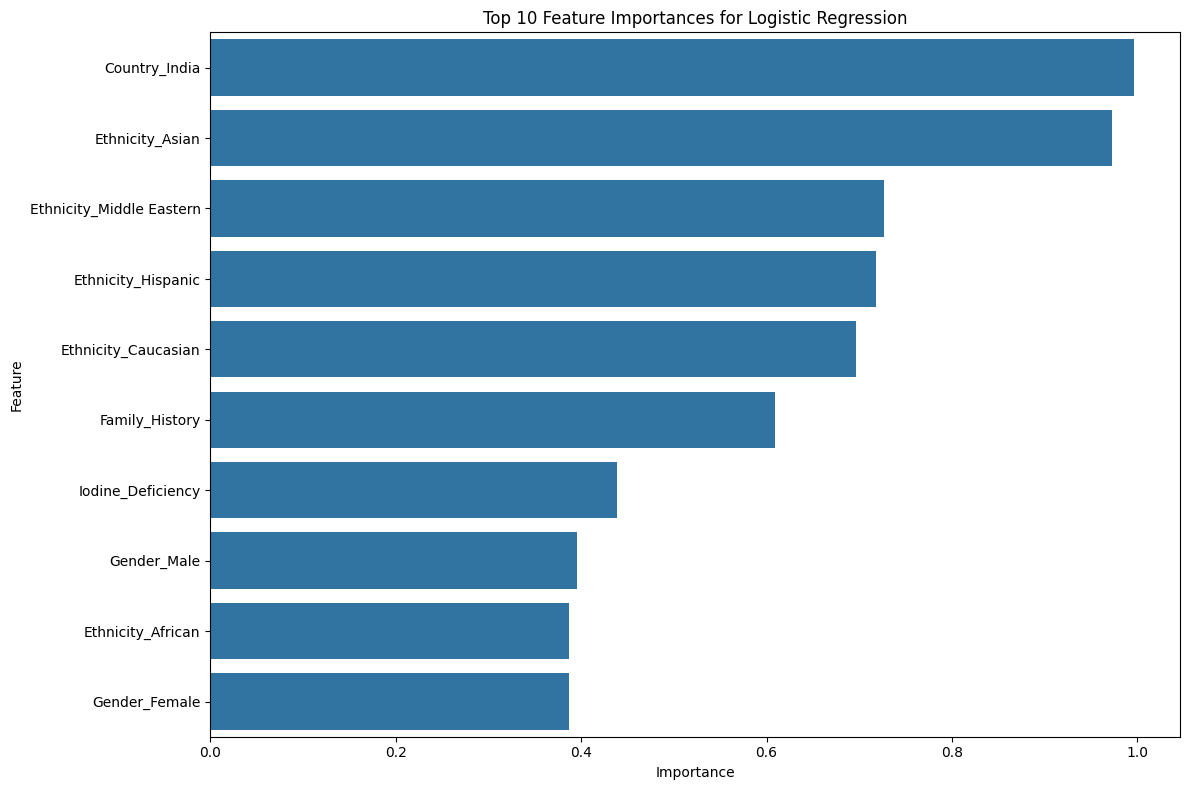


Analysis complete! You now have a working thyroid cancer risk prediction model.


In [5]:
# Data is already loaded from SQLite database in Cell 2
# Display the first few rows to verify the data loaded correctly
print("\nFirst 5 rows of the dataset:")
display(df.head())

# Data info and basic statistics
print("\nDataset Information:")
display(df.info())

print("\nBasic Statistics:")
display(df.describe())

print("\nMissing Values:")
missing_data = pd.DataFrame({
    'Missing Values': df.isnull().sum(),
    'Percentage': (df.isnull().sum() / len(df)) * 100
})
display(missing_data[missing_data['Missing Values'] > 0])

# Data Preprocessing Function
def preprocess_data(df, target_col='Risk_Category'):
    print("\n--- Data Preprocessing ---")

    # Make a copy of the dataframe
    processed_df = df.copy()

    # Check if target column exists
    if target_col not in processed_df.columns:
        print(f"Warning: Target column '{target_col}' not found in dataset.")
        print(f"Available columns: {processed_df.columns.tolist()}")

        # Try to find a column that might be the target
        possible_targets = [col for col in processed_df.columns if 'risk' in col.lower() or 'category' in col.lower()]
        if possible_targets:
            target_col = possible_targets[0]
            print(f"Using '{target_col}' as the target column instead.")
        else:
            # If we can't find a likely target column, use the last column
            target_col = processed_df.columns[-1]
            print(f"Using last column '{target_col}' as the target column.")

    # Handle missing values
    print("\nHandling missing values...")
    for col in processed_df.columns:
        if processed_df[col].isnull().sum() > 0:
            if processed_df[col].dtype in ['int64', 'float64']:
                # For numerical columns, fill with median
                processed_df[col].fillna(processed_df[col].median(), inplace=True)
                print(f"  - Filled missing values in '{col}' with median")
            else:
                # For categorical columns, fill with mode
                processed_df[col].fillna(processed_df[col].mode()[0], inplace=True)
                print(f"  - Filled missing values in '{col}' with mode")

    # Convert target to numerical if it's categorical
    if processed_df[target_col].dtype == 'object':
        print(f"\nEncoding target variable '{target_col}'...")
        label_encoder = LabelEncoder()
        processed_df[target_col] = label_encoder.fit_transform(processed_df[target_col])
        print(f"Target classes: {label_encoder.classes_}")
        print(f"Encoded as: {np.unique(processed_df[target_col])}")

    # Split features and target
    X = processed_df.drop(target_col, axis=1)
    y = processed_df[target_col]

    # Identify numerical and categorical features
    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()

    print(f"\nFeatures:")
    print(f"  - Numerical features: {numerical_features}")
    print(f"  - Categorical features: {categorical_features}")

    # Create preprocessing pipelines
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'  # Include columns not specified in transformers
    )

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"\nData split:")
    print(f"  - Training set: {X_train.shape[0]} samples")
    print(f"  - Test set: {X_test.shape[0]} samples")

    return X_train, X_test, y_train, y_test, preprocessor, numerical_features, categorical_features

# Train and Evaluate Models - Logistic Regression
def build_and_evaluate_models(X_train, X_test, y_train, y_test, preprocessor):
    print("\n--- Model Training and Evaluation ---")

    # Dictionary to store results
    results = {}

    # Train Logistic Regression
    name = 'Logistic Regression'
    model = LogisticRegression(max_iter=1000, random_state=42)

    print(f"\nTraining {name}...")

    # Create pipeline with preprocessing and model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print metrics
    print(f"Performance metrics for {name}:")
    print(f"  - Accuracy: {accuracy:.4f}")
    print(f"  - Precision: {precision:.4f}")
    print(f"  - Recall: {recall:.4f}")
    print(f"  - F1 Score: {f1:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Store results
    results[name] = {
        'model': pipeline,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    best_model_name = 'Logistic Regression'
    print(f"\nModel: {best_model_name}")

    return results, best_model_name

# Analyze Feature Importance - Logistic Regression uses coefficients
def analyze_feature_importance(model_results, best_model_name, X_train, preprocessor, numerical_features, categorical_features):
    print("\n--- Feature Importance Analysis ---")

    # Get the model
    best_model = model_results[best_model_name]['model']

    # For Logistic Regression, use coefficients
    try:
        # Get coefficients (for multi-class, we get one set per class)
        coef = best_model.named_steps['classifier'].coef_
        # Use absolute values and average across classes for multi-class
        if len(coef.shape) > 1:
            importances = np.abs(coef).mean(axis=0)
        else:
            importances = np.abs(coef[0])

        # Get feature names after preprocessing
        feature_names = numerical_features.copy()

        # Get one-hot encoded feature names
        try:
            encoder = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
            cat_feature_names = encoder.get_feature_names_out(categorical_features)
            feature_names.extend(cat_feature_names)
        except:
            # Fallback if encoder structure is different
            for cat_feature in categorical_features:
                feature_names.append(f"{cat_feature}_encoded")

        # Create DataFrame with feature importances
        importance_df = pd.DataFrame({
            'Feature': feature_names[:len(importances)],
            'Importance': importances
        }).sort_values('Importance', ascending=False)

        # Display feature importances
        print("\nTop 10 important features:")
        display(importance_df.head(10))

        # Plot feature importances
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
        plt.title(f'Top 10 Feature Importances for {best_model_name}')
        plt.tight_layout()
        plt.show()

        return importance_df
    except Exception as e:
        print(f"Feature importance visualization not available: {e}")
        return None

# Run the Complete Pipeline
def run_pipeline():
    # Step 1: Preprocess the data
    X_train, X_test, y_train, y_test, preprocessor, numerical_features, categorical_features = preprocess_data(df)

    # Step 2: Build and evaluate models
    model_results, best_model_name = build_and_evaluate_models(X_train, X_test, y_train, y_test, preprocessor)

    # Step 3: Analyze feature importance
    importance_df = analyze_feature_importance(model_results, best_model_name, X_train, preprocessor, numerical_features, categorical_features)

    print("\n--- Pipeline Complete ---")
    print(f"Best model: {best_model_name}")
    print("The thyroid cancer risk assessment model has been successfully built and evaluated.")

    return model_results[best_model_name]['model']


# Step 1: Preprocess data
X_train, X_test, y_train, y_test, preprocessor, numerical_features, categorical_features = preprocess_data(df)

# Step 2: Build and evaluate models
model_results, best_model_name = build_and_evaluate_models(X_train, X_test, y_train, y_test, preprocessor)

# Step 3: Analyze feature importance
importance_df = analyze_feature_importance(model_results, best_model_name, X_train, preprocessor, numerical_features, categorical_features)

print("\nAnalysis complete! You now have a working thyroid cancer risk prediction model.")

In [6]:
# Data is already loaded from SQLite database in Cell 2
# No need to reload

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, silhouette_score, davies_bouldin_score

# Data is already loaded from SQLite database in Cell 2
print("\nFirst 5 rows of the dataset:")
display(df.head())

print("\nDataset Information:")
display(df.info())

print("\nBasic Statistics:")
display(df.describe())

print("\nMissing Values:")
missing_data = pd.DataFrame({
    'Missing Values': df.isnull().sum(),
    'Percentage': (df.isnull().sum() / len(df)) * 100
})
display(missing_data[missing_data['Missing Values'] > 0])


# Preprocessing function
def preprocess_data(df, target_col='Risk_Category'):
    print("\n--- Data Preprocessing ---")
    processed_df = df.copy()

    if target_col not in processed_df.columns:
        print(f"Warning: Target column '{target_col}' not found.")
        possible_targets = [col for col in processed_df.columns if 'risk' in col.lower() or 'category' in col.lower()]
        if possible_targets:
            target_col = possible_targets[0]
            print(f"Using '{target_col}' as target column.")
        else:
            target_col = processed_df.columns[-1]
            print(f"Using last column '{target_col}' as target column.")

    # Handle missing values
    print("\nHandling missing values...")
    for col in processed_df.columns:
        if processed_df[col].isnull().sum() > 0:
            if processed_df[col].dtype in ['int64', 'float64']:
                processed_df[col].fillna(processed_df[col].median(), inplace=True)
                print(f"  - Filled missing values in '{col}' with median")
            else:
                processed_df[col].fillna(processed_df[col].mode()[0], inplace=True)
                print(f"  - Filled missing values in '{col}' with mode")

    # Encode target if needed
    if processed_df[target_col].dtype == 'object':
        print(f"\nEncoding target variable '{target_col}'...")
        label_encoder = LabelEncoder()
        processed_df[target_col] = label_encoder.fit_transform(processed_df[target_col])
        print(f"Classes: {label_encoder.classes_}")

    X = processed_df.drop(target_col, axis=1)
    y = processed_df[target_col]

    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()

    print(f"\nFeatures:")
    print(f"  - Numerical: {numerical_features}")
    print(f"  - Categorical: {categorical_features}")

    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ], remainder='passthrough')

    # 60% Train, 20% Val, 20% Test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    print("\nData Split:")
    print(f"  - Train: {X_train.shape[0]} samples")
    print(f"  - Validation: {X_val.shape[0]} samples")
    print(f"  - Test: {X_test.shape[0]} samples")

    return X_train, X_val, X_test, y_train, y_val, y_test, preprocessor, numerical_features, categorical_features


# Model building and evaluation - Logistic Regression
def build_and_evaluate_models(X_train, X_val, X_test, y_train, y_val, y_test, preprocessor):
    print("\n--- Model Training and Evaluation ---")
    results = {}

    # Train Logistic Regression
    name = 'Logistic Regression'
    model = LogisticRegression(max_iter=1000, random_state=42)

    print(f"\nTraining {name}...")
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Metrics for {name}:")
    print(f"  - Accuracy: {accuracy:.4f}")
    print(f"  - Precision: {precision:.4f}")
    print(f"  - Recall: {recall:.4f}")
    print(f"  - F1 Score: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    results[name] = {
        'model': pipeline,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    best_model_name = 'Logistic Regression'
    print(f"\nModel: {best_model_name}")

    return results, best_model_name


# Feature Importance - Logistic Regression uses coefficients
def analyze_feature_importance(model_results, best_model_name, X_train, preprocessor, numerical_features, categorical_features):
    print("\n--- Feature Importance ---")
    best_model = model_results[best_model_name]['model']

    # For Logistic Regression, use coefficients
    try:
        coef = best_model.named_steps['classifier'].coef_
        if len(coef.shape) > 1:
            importances = np.abs(coef).mean(axis=0)
        else:
            importances = np.abs(coef[0])

        # Get feature names after preprocessing
        feature_names = numerical_features.copy()

        # Get one-hot encoded feature names
        try:
            encoder = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
            cat_feature_names = encoder.get_feature_names_out(categorical_features)
            feature_names.extend(cat_feature_names)
        except:
            # Fallback if encoder structure is different
            for cat_feature in categorical_features:
                feature_names.append(f"{cat_feature}_encoded")

        # Create DataFrame with feature importances
        importance_df = pd.DataFrame({
            'Feature': feature_names[:len(importances)],
            'Importance': importances
        }).sort_values('Importance', ascending=False)

        print("\nTop 10 Important Features:")
        display(importance_df.head(10))

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
        plt.title(f'Top 10 Feature Importances for {best_model_name}')
        plt.tight_layout()
        plt.show()

        return importance_df
    except Exception as e:
        print(f"Feature importance visualization not available: {e}")
        return None


# K-means Clustering
def build_and_evaluate_kmeans(X_train, X_val, X_test, preprocessor, n_clusters=3):
    print("\n--- K-means Clustering ---")

    # Preprocess the data (preprocessor should already be fitted)
    X_train_processed = preprocessor.transform(X_train)
    X_val_processed = preprocessor.transform(X_val)
    X_test_processed = preprocessor.transform(X_test)

    # Fit K-means on training data
    print(f"\nFitting K-means with {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X_train_processed)

    # Predict clusters on train, validation, and test sets
    train_clusters = kmeans.predict(X_train_processed)
    val_clusters = kmeans.predict(X_val_processed)
    test_clusters = kmeans.predict(X_test_processed)

    # Calculate Silhouette Score (higher is better, range -1 to 1)
    train_silhouette = silhouette_score(X_train_processed, train_clusters)
    val_silhouette = silhouette_score(X_val_processed, val_clusters)
    test_silhouette = silhouette_score(X_test_processed, test_clusters)

    # Calculate Davies-Bouldin Score (lower is better)
    train_db = davies_bouldin_score(X_train_processed, train_clusters)
    val_db = davies_bouldin_score(X_val_processed, val_clusters)
    test_db = davies_bouldin_score(X_test_processed, test_clusters)

    print(f"\nK-means Evaluation Metrics:")
    print(f"Training Set:")
    print(f"  - Silhouette Score: {train_silhouette:.4f}")
    print(f"  - Davies-Bouldin Score: {train_db:.4f}")
    print(f"\nValidation Set:")
    print(f"  - Silhouette Score: {val_silhouette:.4f}")
    print(f"  - Davies-Bouldin Score: {val_db:.4f}")
    print(f"\nTest Set:")
    print(f"  - Silhouette Score: {test_silhouette:.4f}")
    print(f"  - Davies-Bouldin Score: {test_db:.4f}")

    # Store results
    kmeans_results = {
        'model': kmeans,
        'preprocessor': preprocessor,
        'n_clusters': n_clusters,
        'train_silhouette': train_silhouette,
        'val_silhouette': val_silhouette,
        'test_silhouette': test_silhouette,
        'train_db': train_db,
        'val_db': val_db,
        'test_db': test_db,
        'train_clusters': train_clusters,
        'val_clusters': val_clusters,
        'test_clusters': test_clusters
    }

    return kmeans_results





First 5 rows of the dataset:


,Patient_Id,Age,Gender,Country,Ethnicity,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,Tsh_Level,T3_Level,T4_Level,Nodule_Size,Risk_Category
0,1,66,Male,Russia,Caucasian,0,1,0,0,0,0,9.37,1.67,6.16,1.08,Low
1,2,29,Male,Germany,Hispanic,0,1,0,0,0,0,1.83,1.73,10.54,4.05,Low
2,3,86,Male,Nigeria,Caucasian,0,0,0,0,0,0,6.26,2.59,10.57,4.61,Low
3,4,75,Female,India,Asian,0,0,0,0,0,0,4.10,2.62,11.04,2.46,Medium
4,5,35,Female,Germany,African,1,1,0,0,0,0,9.10,2.11,10.71,2.11,High



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212691 entries, 0 to 212690
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Patient_Id          212691 non-null  int64  
 1   Age                 212691 non-null  int64  
 2   Gender              212691 non-null  object 
 3   Country             212691 non-null  object 
 4   Ethnicity           212691 non-null  object 
 5   Family_History      212691 non-null  int64  
 6   Radiation_Exposure  212691 non-null  int64  
 7   Iodine_Deficiency   212691 non-null  int64  
 8   Smoking             212691 non-null  int64  
 9   Obesity             212691 non-null  int64  
 10  Diabetes            212691 non-null  int64  
 11  Tsh_Level           212691 non-null  float64
 12  T3_Level            212691 non-null  float64
 13  T4_Level            212691 non-null  float64
 14  Nodule_Size         212691 non-null  float64
 15  Risk_Categor

None


Basic Statistics:


,Patient_Id,Age,Family_History,Radiation_Exposure,Iodine_Deficiency,Smoking,Obesity,Diabetes,Tsh_Level,T3_Level,T4_Level,Nodule_Size
count,212691.00000,212691.000000,212691.000000,212691.000000,212691.000000,212691.000000,212691.00000,212691.000000,212691.000000,212691.000000,212691.000000,212691.000000
mean,106346.00000,51.918497,0.300083,0.149795,0.249272,0.199496,0.30037,0.200258,5.045102,2.001727,8.246204,2.503403
std,61398.74739,21.632815,0.458295,0.356871,0.432593,0.399622,0.45842,0.400194,2.860264,0.866248,2.164188,1.444631
min,1.00000,15.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.100000,0.500000,4.500000,0.000000
25%,53173.50000,33.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,2.570000,1.250000,6.370000,1.250000
50%,106346.00000,52.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,5.040000,2.000000,8.240000,2.510000
75%,159518.50000,71.000000,1.000000,0.000000,0.000000,0.000000,1.00000,0.000000,7.520000,2.750000,10.120000,3.760000
max,212691.00000,89.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,10.000000,3.500000,12.000000,5.000000



Missing Values:


,Missing Values,Percentage



--- Data Preprocessing ---

Handling missing values...

Encoding target variable 'Risk_Category'...
Classes: ['High' 'Low' 'Medium']

Features:
  - Numerical: ['Patient_Id', 'Age', 'Family_History', 'Radiation_Exposure', 'Iodine_Deficiency', 'Smoking', 'Obesity', 'Diabetes', 'Tsh_Level', 'T3_Level', 'T4_Level', 'Nodule_Size']
  - Categorical: ['Gender', 'Country', 'Ethnicity']

Data Split:
  - Train: 127614 samples
  - Validation: 42538 samples
  - Test: 42539 samples

--- K-means Clustering ---

Fitting K-means with 3 clusters...

K-means Evaluation Metrics:
Training Set:
  - Silhouette Score: 0.1069
  - Davies-Bouldin Score: 2.7592

Validation Set:
  - Silhouette Score: 0.1075
  - Davies-Bouldin Score: 2.7610

Test Set:
  - Silhouette Score: 0.1067
  - Davies-Bouldin Score: 2.7547

--- Model Training and Evaluation ---

Training Logistic Regression...
Metrics for Logistic Regression:
  - Accuracy: 0.6038
  - Precision: 0.4076
  - Recall: 0.6038
  - F1 Score: 0.4814

Classification R

,Feature,Importance
17,Country_India,0.997666
25,Ethnicity_Asian,0.969289
28,Ethnicity_Middle Eastern,0.726081
27,Ethnicity_Hispanic,0.705692
26,Ethnicity_Caucasian,0.701955
2,Family_History,0.607014
4,Iodine_Deficiency,0.439239
13,Gender_Male,0.396862
24,Ethnicity_African,0.383866
12,Gender_Female,0.383710


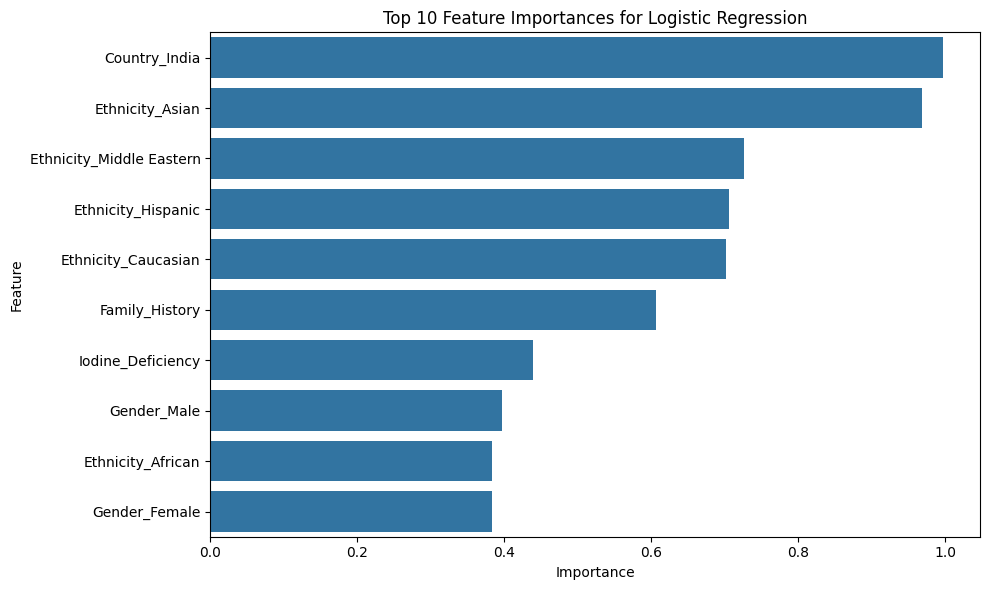


--- Pipeline Complete ---


In [8]:
# Run pipeline
def run_pipeline():
    X_train, X_val, X_test, y_train, y_val, y_test, preprocessor, numerical_features, categorical_features = preprocess_data(df)

    # Fit preprocessor on training data (needed for K-means, Pipeline will refit it anyway)
    preprocessor.fit(X_train)

    # K-means Clustering
    kmeans_results = build_and_evaluate_kmeans(X_train, X_val, X_test, preprocessor, n_clusters=3)

    # Logistic Regression and other models
    model_results, best_model_name = build_and_evaluate_models(X_train, X_val, X_test, y_train, y_val, y_test, preprocessor)
    importance_df = analyze_feature_importance(model_results, best_model_name, X_train, preprocessor, numerical_features, categorical_features)

    print("\n--- Pipeline Complete ---")
    return model_results[best_model_name]['model'], kmeans_results


# Execute
best_model, kmeans_results = run_pipeline()

In [9]:
!pip install gradio pandas scikit-learn matplotlib seaborn openpyxl


In [10]:
import gradio as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, silhouette_score, davies_bouldin_score # Added for K-means
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans # Added for K-means
import io
import base64

# Load your dataset
try:
    file_path = "thyroid_cancer_risk_data.csv"
    df = pd.read_csv(file_path)
    print("Successfully loaded data from:", file_path)
except Exception as e:
    print(f"Error loading data: {e}")
    # Create mock data if real data isn't available
    np.random.seed(42)
    n = 500
    data = {
        'Age': np.random.randint(20, 80, n),
        'Gender': np.random.choice(['Male', 'Female'], n),
        'TSH_Level': np.random.normal(2.5, 1.5, n),
        'T3_Level': np.random.normal(1.2, 0.3, n),
        'T4_Level': np.random.normal(1.2, 0.3, n),
        'Nodule_Size': np.random.normal(1.0, 0.8, n),
        'Family_History': np.random.choice(['Yes', 'No'], n),
        'Radiation_Exposure': np.random.choice(['Yes', 'No'], n),
        'Iodine_Deficiency': np.random.choice(['Yes', 'No'], n),
        'Thyroid_Cancer_Risk': np.random.choice(['Low', 'Medium', 'High'], n, p=[0.6, 0.3, 0.1])
    }
    df = pd.DataFrame(data)

# Data preprocessing function
def preprocess_data(df, target_col='Thyroid_Cancer_Risk'):
    processed_df = df.copy()

    # Handle missing values
    for col in processed_df.columns:
        if processed_df[col].isnull().sum() > 0:
            if processed_df[col].dtype in ['int64', 'float64']:
                processed_df[col].fillna(processed_df[col].median(), inplace=True)
            else:
                processed_df[col].fillna(processed_df[col].mode()[0], inplace=True)

    # Convert target to numerical if it's categorical
    if processed_df[target_col].dtype == 'object':
        label_encoder = LabelEncoder()
        processed_df[target_col] = label_encoder.fit_transform(processed_df[target_col])
        target_classes = label_encoder.classes_
    else:
        target_classes = [f"Class {i}" for i in np.unique(processed_df[target_col])]

    # Split features and target
    X = processed_df.drop(target_col, axis=1)
    y = processed_df[target_col]

    # Identify numerical and categorical features
    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()

    # Create preprocessing pipelines
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    return X_train, X_test, y_train, y_test, preprocessor, numerical_features, categorical_features, target_classes

# Train models function - Logistic Regression
def train_models(X_train, X_test, y_train, y_test, preprocessor):
    results = {}

    # Train Logistic Regression
    name = 'Logistic Regression'
    model = LogisticRegression(max_iter=1000, random_state=42)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results[name] = {
        'model': pipeline,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'y_test': y_test,
        'y_pred': y_pred
    }

    model_comparison = pd.DataFrame({
        'Model': [name],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1]
    })

    best_model_name = 'Logistic Regression'

    return results, best_model_name, model_comparison

# Feature importance analysis - Logistic Regression uses coefficients
def get_feature_importance(model_results, best_model_name, numerical_features, categorical_features):
    best_model = model_results[best_model_name]['model']

    # For Logistic Regression, use coefficients
    try:
        coef = best_model.named_steps['classifier'].coef_
        # Handle multi-class: average absolute coefficients across classes
        if len(coef.shape) > 1:
            importances = np.abs(coef).mean(axis=0)
        else:
            importances = np.abs(coef[0])

        # Get feature names after preprocessing
        try:
            feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
        except:
            # Fallback: construct feature names manually
            feature_names = numerical_features.copy()
            try:
                encoder = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
                cat_feature_names = encoder.get_feature_names_out(categorical_features)
                feature_names.extend(cat_feature_names)
            except:
                for cat_feature in categorical_features:
                    feature_names.append(f"{cat_feature}_encoded")

        importance_df = pd.DataFrame({
            'Feature': feature_names[:len(importances)],
            'Importance': importances
        }).sort_values('Importance', ascending=False)

        return importance_df
    except Exception as e:
        print(f"Error getting feature importance: {e}")
        return pd.DataFrame({'Feature': ['Not available'], 'Importance': [0]})

def create_feature_importance_plot(importance_df):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
    plt.title('Top 10 Feature Importances')
    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)
    return base64.b64encode(buf.read()).decode('utf-8')

def create_model_comparison_plot(model_comparison):
    plt.figure(figsize=(12, 6))
    model_comparison.set_index('Model').plot(kind='bar', figsize=(12, 6))
    plt.title('Model Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)
    return base64.b64encode(buf.read()).decode('utf-8')

def create_distribution_plot(df, target_column):
    plt.figure(figsize=(8, 6))
    df[target_column].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {target_column}')
    plt.xlabel(target_column)
    plt.ylabel('Count')
    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)
    return base64.b64encode(buf.read()).decode('utf-8')

# K-means Clustering (adapted for train and test splits only)
def build_and_evaluate_kmeans(X_train, X_test, preprocessor, n_clusters=3):
    print("\n--- K-means Clustering ---")

    # Fit and transform preprocessor on training data, transform test data
    # Note: preprocessor here refers to the ColumnTransformer that is NOT yet fitted.
    # We need to fit it here first.
    # Create a copy of the preprocessor to fit within this function scope
    kmeans_preprocessor = ColumnTransformer(
        transformers=preprocessor.transformers,
        remainder=preprocessor.remainder
    )

    X_train_processed = kmeans_preprocessor.fit_transform(X_train)
    X_test_processed = kmeans_preprocessor.transform(X_test)

    # Fit K-means on training data
    print(f"\nFitting K-means with {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X_train_processed)

    # Predict clusters on train and test sets
    train_clusters = kmeans.predict(X_train_processed)
    test_clusters = kmeans.predict(X_test_processed)

    # Calculate Silhouette Score (higher is better, range -1 to 1)
    train_silhouette = silhouette_score(X_train_processed, train_clusters)
    test_silhouette = silhouette_score(X_test_processed, test_clusters)

    # Calculate Davies-Bouldin Score (lower is better)
    train_db = davies_bouldin_score(X_train_processed, train_clusters)
    test_db = davies_bouldin_score(X_test_processed, test_clusters)

    print(f"\nK-means Evaluation Metrics:")
    print(f"Training Set:")
    print(f"  - Silhouette Score: {train_silhouette:.4f}")
    print(f"  - Davies-Bouldin Score: {train_db:.4f}")
    print(f"\nTest Set:")
    print(f"  - Silhouette Score: {test_silhouette:.4f}")
    print(f"  - Davies-Bouldin Score: {test_db:.4f}")

    # Store results
    kmeans_results = {
        'model': kmeans,
        'n_clusters': n_clusters,
        'train_silhouette': train_silhouette,
        'test_silhouette': test_silhouette,
        'train_db': train_db,
        'test_db': test_db,
        'train_clusters': train_clusters,
        'test_clusters': test_clusters
    }

    return kmeans_results

# Preprocess and train models
X_train, X_test, y_train, y_test, preprocessor, numerical_features, categorical_features, target_classes = preprocess_data(df)
target_column = 'Thyroid_Cancer_Risk'
model_results, best_model_name, model_comparison = train_models(X_train, X_test, y_train, y_test, preprocessor)
importance_df = get_feature_importance(model_results, best_model_name, numerical_features, categorical_features)
best_model = model_results[best_model_name]['model']

# Run K-means clustering
kmeans_results = build_and_evaluate_kmeans(X_train, X_test, preprocessor, n_clusters=3)

# Create plots here

# Create model comparison plot
model_comparison_img = create_model_comparison_plot(model_comparison)

# Create feature importance plot
feature_importance_img = create_feature_importance_plot(importance_df)

# Create distribution plot
distribution_img = create_distribution_plot(df, target_column)

# Prediction function
def predict_risk(*args):
    features = list(X_train.columns)
    input_dict = {features[i]: [args[i]] for i in range(len(features))}
    input_data = pd.DataFrame(input_dict)

    prediction = best_model.predict(input_data)
    prediction_proba = best_model.predict_proba(input_data)

    predicted_class = target_classes[prediction[0]]

    risk_probs = {
        target_classes[i]: f"{prediction_proba[0][i]*100:.2f}%"
        for i in range(len(target_classes))
    }

    # Get top 3 important features for this prediction
    try:
        coef = best_model.named_steps['classifier'].coef_
        # Handle multi-class: average absolute coefficients across classes
        if len(coef.shape) > 1:
            importances = np.abs(coef).mean(axis=0)
        else:
            importances = np.abs(coef[0])

        # Get feature names
        try:
            feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
        except:
            feature_names = numerical_features.copy()
            try:
                encoder = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
                cat_feature_names = encoder.get_feature_names_out(categorical_features)
                feature_names.extend(cat_feature_names)
            except:
                for cat_feature in categorical_features:
                    feature_names.append(f"{cat_feature}_encoded")

        sorted_idx = importances.argsort()[::-1]
        top_features = [feature_names[i] for i in sorted_idx[:3] if i < len(feature_names)]
        key_factors = f"Top factors: {', '.join(top_features)}"
    except:
        key_factors = "Key factors not available for this prediction"

    risk_summary = f"Predicted {target_column}: {predicted_class}\n\n"
    risk_summary += "Prediction Probabilities:\n"
    for risk_class, prob in risk_probs.items():
        risk_summary += f"- {risk_class}: {prob}\n"
    risk_summary += f"\n{key_factors}"

    return risk_summary

# Create Gradio interface
with gr.Blocks(title="Thyroid Cancer Risk Prediction") as app:
    gr.Markdown("# Thyroid Cancer Risk Prediction Model")
    gr.Markdown(f"Predicting: **{target_column}**")
    gr.Markdown(f"Best performing model: **{best_model_name}** (F1 Score: {model_results[best_model_name]['f1']:.4f})")

    with gr.Tabs():
        with gr.TabItem("Make Prediction"):
            gr.Markdown("## Enter Patient Information")

            input_components = []
            features = list(X_train.columns)
            mid_point = len(features) // 2

            with gr.Row():
                with gr.Column():
                    for i, feature in enumerate(features[:mid_point]):
                        if feature in numerical_features:
                            min_val = float(df[feature].min())
                            max_val = float(df[feature].max())
                            default_val = float(df[feature].median())

                            min_val = round(min_val, 2)
                            max_val = round(max_val, 2)
                            default_val = round(default_val, 2)

                            if min_val == max_val:
                                min_val = max(0, min_val - 1)
                                max_val = max_val + 1

                            input_components.append(gr.Slider(
                                min_val, max_val, value=default_val, label=feature
                            ))
                        else:
                            unique_values = df[feature].unique().tolist()
                            default_val = df[feature].mode()[0]
                            input_components.append(gr.Radio(
                                unique_values, label=feature, value=default_val
                            ))

                with gr.Column():
                    for i, feature in enumerate(features[mid_point:]):
                        if feature in numerical_features:
                            min_val = float(df[feature].min())
                            max_val = float(df[feature].max())
                            default_val = float(df[feature].median())

                            min_val = round(min_val, 2)
                            max_val = round(max_val, 2)
                            default_val = round(default_val, 2)

                            if min_val == max_val:
                                min_val = max(0, min_val - 1)
                                max_val = max_val + 1

                            input_components.append(gr.Slider(
                                min_val, max_val, value=default_val, label=feature
                            ))
                        else:
                            unique_values = df[feature].unique().tolist()
                            default_val = df[feature].mode()[0]
                            input_components.append(gr.Radio(
                                unique_values, label=feature, value=default_val
                            ))

            predict_btn = gr.Button(f"Predict {target_column}")

            with gr.Row():
                with gr.Column():
                    output = gr.Textbox(label="Risk Assessment Results", lines=10)

            predict_btn.click(
                fn=predict_risk,
                inputs=input_components,
                outputs=output
            )

        with gr.TabItem("Model Performance"):
            gr.Markdown("## Logistic Regression: Relevant Scores")

            with gr.Row():
                with gr.Column():
                    gr.Markdown("### Logistic Regression: Relevant Scores")
                    gr.HTML(f"<img src='data:image/png;base64,{model_comparison_img}' style='max-width:100%;'>")

                with gr.Column():
                    gr.Markdown("### K-means Clustering: Relevant Scores")
                    kmeans_metrics_md = f"""
                    | Metric | Value |
                    | ------ | ----- |
                    | Silhouette Score | {kmeans_results['test_silhouette']:.4f} |
                    | Davies-Bouldin Score | {kmeans_results['test_db']:.4f} |
                    """
                    gr.Markdown(kmeans_metrics_md)

            with gr.Row():
                with gr.Column():
                    gr.Markdown("### Feature Importance")
                    gr.HTML(f"<img src='data:image/png;base64,{feature_importance_img}' style='max-width:100%;'>")


        with gr.TabItem("Data Overview"):
            gr.Markdown("## Dataset Information")

            with gr.Row():
                with gr.Column():
                    gr.Markdown("### Data Sample")
                    gr.DataFrame(df.head())

                with gr.Column():
                    gr.Markdown("### Data Statistics")
                    stats_md = f"""
                    - **Number of samples**: {len(df)}
                    - **Number of features**: {len(df.columns) - 1}
                    - **Target variable**: {target_column}
                    - **Target Classes**: {', '.join(map(str, target_classes))}
                    - **Numerical features**: {', '.join(numerical_features)}
                    - **Categorical features**: {', '.join(categorical_features)}
                    """
                    gr.Markdown(stats_md)

            with gr.Row():
                with gr.Column():
                    gr.Markdown("### Data Distribution")
                    gr.HTML(f"<img src='data:image/png;base64,{distribution_img}' style='max-width:100%;'>")

# Launch the app
app.launch()

Successfully loaded data from: thyroid_cancer_risk_data.csv

--- K-means Clustering ---

Fitting K-means with 3 clusters...

K-means Evaluation Metrics:
Training Set:
  - Silhouette Score: 0.0584
  - Davies-Bouldin Score: 3.2227

Test Set:
  - Silhouette Score: 0.0584
  - Davies-Bouldin Score: 3.2238
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cc21e4bd971a3db304.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


<Figure size 1200x600 with 0 Axes>